Copyright 2019 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

**FEEDBACK REQUEST** thanks for checking out this notebook demoing our experimental API. After using this, we would greatly appreciate your feedback. You can send us feedback by:

- Sending an issue request to the [datacommons issues page](https://github.com/google/datacommons/issues). When creating an issue please mark the issue using the **api feedback** label!

**DISCLAIMER** this notebook uses an experimental version of the Data Commons Python API. The semantics and availability of this API may be subject to change without prior notice! 

# Getting Started with the Python API

This tutorial introduces the Data Commons open knowledge graph and discusses how to programmtically access its data through the Python API. We will use the task of plotting employment data provided by the Bureau of Labor Statistics as an example to demonstrate various functionalities supported by the Python API.

Before proceeding, we will need to install the Python API package.

In [9]:
# Install datacommons
!pip install --upgrade --quiet git+https://github.com/datacommonsorg/api-python.git@stable-1.x

## What is Data Commons?

Data Commons is an open knowledge graph of structured data. It contains statements about real world objects such as

* [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) is contained in the [State of California](https://browser.datacommons.org/kg?dcid=geoId/06)
* The latitude of [Berkeley, CA](https://browser.datacommons.org/kg?dcid=geoId/0606000) is 37.8703
* The [population of all persons in Maryland ](https://browser.datacommons.org/kg?dcid=dc/o/6w1c9qk7hxjch)has a total count of 5,996,080.

In the graph, [*entities*](https://en.wikipedia.org/wiki/Entity) like [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) are represented by nodes. Every node is uniquely identified by its **`dcid`** (Data Commons Identifier) and has a **`type`** corresponding to what the node represents. For example, [California](https://browser.datacommons.org/kg?dcid=geoId/06) is identified by the dcid `geoId/06` and is of type [State](https://browser.datacommons.org/kg?dcid=State). *Relations* between entities are represented by directed edges between these nodes. For example, the statement "Santa Clara County is contained in the State of California" is represented in the graph as two nodes: "Santa Clara County" and "California" with an edge labeled "[containedInPlace](https://schema.org/containedInPlace)" pointing from Santa Clara to California. This can be visualized by the following diagram.

![A portion of the Data Commons graph](https://storage.googleapis.com/notebook-resources/image-1.png)

Here, we call the edge label, "containedInPlace", the *property label* (or *property* for short) associated with the above relation. We may also refer to "California" as the *property value* associated with Santa Clara County along property "containedInPlace". 

Notice that the direction is important! One can say that "Santa Clara County" is containedInPlace of "California", but "California" is certainly not contained in "Santa Clara County"! In general, how Data Commons models data is similar to the [Schema.org](https://schema.org) Data Model as  Data Commons leverages schema.org to provide a common set of types and properties. For a broader discussion on how data is modeled in Data Commons, one can refer to documentation on the [Schema.org data model](https://schema.org/docs/datamodel.html).

### The Data Commons Browser

Throughout this tutorial, we will be using the [Data Commons browser](https://browser.datacommons.org). The browser provides a human readable way of navigating nodes within the knowledge graph. This is particularly useful for discovering what parameters to pass into the Python API in order to correctly query for nodes in the graph. 

## The Python API

The Python API provides functions for users to programmatically access nodes in the Data Commons open knowledge graph. In this tutorial, we will be demonstrating how to use the API access nodes in the Data Commons graph and store their information in a [Pandas](https://pandas.pydata.org) Data Frame. For a discussion on how to use the API generally, please refer to the [API Documentation](https://datacommons.readthedocs.io/en/dev2/).

Let's begin by importing the Python Client and other helpful libraries.



In [0]:
import datacommons as dc
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

import json

# Pandas display options
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 30

We will also need to provide an API key to the library. Please refer to [Getting Started](https://datacommons.readthedocs.io/en/latest/started.html) for more details about how to get an API key. Once you have a key, we can provided it to the library by calling [**`set_api_key`**](https://datacommons.readthedocs.io/en/latest/_autosummary/datacommons_utils/datacommons.utils.set_api_key.html#datacommons.utils.set_api_key). 

In [11]:
# Mount the Drive
drive.mount('/content/drive', force_remount=True)

# REPLACE THIS with the path to your key if copying this notebook.
key_path = '/content/drive/My Drive/DataCommons/secret.json'

# Read the key in and provide it to the Data Commons API
with open(key_path, 'r') as f:
  secrets = json.load(f)
  dc.set_api_key(secrets['dc_api_key'])

Mounted at /content/drive


To keep the API key a secret, we store it in a JSON file in Google Drive. The file is pointed to by `key_path` and takes the form

```json
{
  "dc_api_key": "YOUR-API-KEY"
}
```

The above cell reads the JSON file, and loads the key into the library. If you want to make a copy of this notebook, be sure to create your own `secret.json` file and provide its path to `key_path`.

## Using the API To Plot Unemployment Data

The [Bureau of Labor Statistics](https://www.bls.gov) provides a monthly count for number of individuals who are employed at the State, County, and City level. This data is surfaced in the Data Commons; for example, one can find employment statistics associated with Santa Clara County [here](https://browser.datacommons.org/kg?dcid=dc/p/y6xm2mny8mck1&db=). Our task for this tutorial will be to extract employment data associated with counties in California from Data Commons using the Python API and view it in a Pandas DataFrame. We will focus on how functions such as

- `get_property_values`
- `get_places_in`
- `get_populations`
- `get_observations`

operate when using a Pandas DataFrame, as well as how statistical observations are modeled within the Data Commons graph. To begin, we will initialize a Pandas Data Frame with the dcid associated with California: [geoId/06](https://browser.datacommons.org/kg?dcid=geoId/06).





In [12]:
# Initialize the Data Frame
data = pd.DataFrame({'state': ['geoId/06']})

# View the frame
print(data)

      state
0  geoId/06


### Accessing Properties of a Node

For all properties, one can use **`get_property_value`** to get the associated values. We would like to know that the dcid we have in our data frame belongs to California by getting the name of the node identified by "geoId/06". `get_property_value` accepts the following parameters.

- **`dcids`** - A list or Pandas Series of dcids to get property values for.
- **`prop`** - The property to get property values for.
- **`out`**`[=True]` - An optional flag that indicates the property is oriented away from the given nodes if true.
- **`value_type`**`[=None]` - An optional parameter which filters property values by the given type. 
- **`limit`**`[=100]` - An optional parameter which limits the total number of property values returned *aggregated over all given nodes*.

When the dcids are given as a [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html), the returned list of property values is a Pandas Series where the i-th entry corresponds to property values associated with the i-th given dcid. Some properties, like [containedInPlace](https://browser.datacommons.org/kg?dcid=containedInPlace), may have many property values. Consequently, the cells of the returned series will always contain a list of property values. Let's take a look:

In [13]:
# Call get_property_values. Because the return value is a Pandas Series, we can 
# assign it directly to a column in our frame.
data['state_name'] = dc.get_property_values(data['state'], 'name')

# Display the frame
print(data)

      state    state_name
0  geoId/06  [California]


For each list in the returned column, we may need to expand each element of the list into its own row. If one uses Pandas version >= 0.25, then this can easily be achieved by calling [`series.explode`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.explode.html). Otherwise, we can call a convenience function `flatten_frame`.

In [14]:
# Call flatten_frame, but don't store the results.
print(dc.flatten_frame(data))

      state  state_name
0  geoId/06  California


We won't store the results of calling this for now in order to show case a feature in the next section!

### Working with Places in Data Commons

We would now like to get all Counties contained in California. This can be achieved by calling `get_property_value`, but because a large fraction of use cases will involve accessing geographical locations, the API also implements a function, **`get_places_in`**, to get places contained within a list of given places. `get_places_in` accepts the following parameters.

- **`dcids`** - A list or Pandas Series of dcids to get contained in places.
- **`place_type`** - The type of places contained in the given dcids to query for.

When dcids is specified as a Pandas Series, the return value is a Series with the same format as that returned by `get_property_values`. Let's call `get_places_in` to get all counties within California.

In [15]:
# Call get_places_in to get all counties in California. Here the type we use is 
# "County". See https://browser.datacommons.org/kg?dcid=County for examples of 
# other nodes in the graph with type "County".
data['county'] = dc.get_places_in(data['state'], 'County')

# Display the frame
print(data)

      state    state_name                         county
0  geoId/06  [California]  [geoId/06001, geoId/06003,...


Notice that both `state_name` and `county` columns are columns with list. `flatten_frame` will automaticall flatten all columns that have lists in their cells. Optionally, one can provide the argument `cols` to specify which columns to flatten.

In [16]:
# Call flatten frame
data = dc.flatten_frame(data)

# Display the frame
print(data)

       state  state_name       county
0   geoId/06  California  geoId/06001
1   geoId/06  California  geoId/06003
2   geoId/06  California  geoId/06005
3   geoId/06  California  geoId/06007
4   geoId/06  California  geoId/06009
..       ...         ...          ...
53  geoId/06  California  geoId/06107
54  geoId/06  California  geoId/06109
55  geoId/06  California  geoId/06111
56  geoId/06  California  geoId/06113
57  geoId/06  California  geoId/06115

[58 rows x 3 columns]


Let's now get the names for each column like above. Notice we need to unroll the `county` column, as the input to `get_property_values` is a Series of dcids and not a Series of lists of dcids.

In [17]:
# Get the names of all counties in California.
data['county_name'] = dc.get_property_values(data['county'], 'name')
data = dc.flatten_frame(data)

# Display the frame
data

,state,state_name,county,county_name
0,geoId/06,California,geoId/06001,Alameda County
1,geoId/06,California,geoId/06003,Alpine County
2,geoId/06,California,geoId/06005,Amador County
3,geoId/06,California,geoId/06007,Butte County
4,geoId/06,California,geoId/06009,Calaveras County
...,...,...,...,...
53,geoId/06,California,geoId/06107,Tulare County
54,geoId/06,California,geoId/06109,Tuolumne County
55,geoId/06,California,geoId/06111,Ventura County
56,geoId/06,California,geoId/06113,Yolo County


In [18]:
dc.get_places_in(['geoId/06'], 'County')

{'geoId/06': ['geoId/06001',
  'geoId/06003',
  'geoId/06005',
  'geoId/06007',
  'geoId/06009',
  'geoId/06011',
  'geoId/06013',
  'geoId/06015',
  'geoId/06017',
  'geoId/06019',
  'geoId/06021',
  'geoId/06023',
  'geoId/06025',
  'geoId/06027',
  'geoId/06029',
  'geoId/06031',
  'geoId/06033',
  'geoId/06035',
  'geoId/06037',
  'geoId/06039',
  'geoId/06041',
  'geoId/06043',
  'geoId/06045',
  'geoId/06047',
  'geoId/06049',
  'geoId/06051',
  'geoId/06053',
  'geoId/06055',
  'geoId/06057',
  'geoId/06059',
  'geoId/06061',
  'geoId/06063',
  'geoId/06065',
  'geoId/06067',
  'geoId/06069',
  'geoId/06071',
  'geoId/06073',
  'geoId/06075',
  'geoId/06077',
  'geoId/06079',
  'geoId/06081',
  'geoId/06083',
  'geoId/06085',
  'geoId/06087',
  'geoId/06089',
  'geoId/06091',
  'geoId/06093',
  'geoId/06095',
  'geoId/06097',
  'geoId/06099',
  'geoId/06101',
  'geoId/06103',
  'geoId/06105',
  'geoId/06107',
  'geoId/06109',
  'geoId/06111',
  'geoId/06113',
  'geoId/06115']}

### Working with Statistical Observations

Finally, we are ready to query for Employment statistics in Data Commons. Before proceeding, we discuss briefly about how Data Commons models statistics. 

Statistical observations can be separated into two types of entities: the *statistical population* that the observation is describing, and the *observation* itself. A statistic such as

> The number of employed individuals living in Santa Clara in January 2018 was 1,015,129

can thus be represented by two entities: one capturing the population of *all persons who are unemployed* and another capturing the observation 1,015,129 made in January 2018. Data Commons represents these two entity types as `StatisticalPopulation` and `Observation`. Let's now focus on each separate one.

#### StatisticalPopulations

Consider the [node's browser page](https://browser.datacommons.org/kg?dcid=dc/p/y6xm2mny8mck1&db=) representing the `StatisticalPopulation` of all employed persons living in Santa Clara County. 

![The population of employed individuals in Santa Clara County](https://storage.googleapis.com/notebook-resources/image-2.png)

At the top of the browser page, we are presented a few properties of this node to consider:

- The **`typeOf`** this node is `StatisticalPopulation` as expected.
- The **`populationType`** is `Person` telling us that this is a statistical population describing persons.
- The **`location`** of this node is [Santa Clara County](https://browser.datacommons.org/kg?dcid=geoId/06085) telling us that the persons in this statistical population live in Santa Clara County.
- The **`dcid`** property tells us the dcid of this node
- The **`localCuratorLevelId`** tells us information about how this node was uploaded to the graph. For the purposes of this tutorial, we can ignore this field.

There are two other properties defined: `numConstraints` and `employment`. These two properties help us describe entities contained in this statistical population. Properties used to describe the entities captured by a StatisticalPopulation are called *constraining properties*. In the example above, `employment=BLS_Employed` is a constraining property that tells us the Statistical Population captures employed persons. `numConstraints` denotes how many constraining properties there are, and in the example above, `numConstraints=1` tells us that `employment` is the only constraining property.

To query for `StatisticalPopulation`s using the Data Commons Python API, we call **`get_populations`**. The function accepts the following parameters.

- **`dcids`** - A list or Pandas Series of dcids denoting the locations of populations to query for.
- **`population_type`** - The `populationType` of the `StatisticalPopulation`
- **`constraining_properties`**`[={}]` - An optional map from constraining property to the value that the `StatisticalPopulation` should be constrained by.

When a Pandas Series is provided to `dcids`, the return value is a Series with each cell populated by a single dcid and not a list. This is because the combination of `dcids`, `population_type`, and optionally `constraining_properties` always map to a unique statistical population `dcid` if it exists.

Let's call `get_populations` to get the populations of all employed individuals living in counties specified by the `county` column of our DataFrame.

In [19]:
# First we create the constraining_properties map
props = {'employment': 'BLS_Employed'}

# We now call get_populations.
data['employed_pop'] = dc.get_populations(
    data['county'], 'Person', constraining_properties=props)


# Display the DataFrame. Notice that we don't need to flatten the frame.
data

,state,state_name,county,county_name,employed_pop
0,geoId/06,California,geoId/06001,Alameda County,dc/p/69mjbvx3c6m38
1,geoId/06,California,geoId/06003,Alpine County,dc/p/38cz2egkw07rb
2,geoId/06,California,geoId/06005,Amador County,dc/p/d0tgg3hcqwevh
3,geoId/06,California,geoId/06007,Butte County,dc/p/fn9p8qqppptdf
4,geoId/06,California,geoId/06009,Calaveras County,dc/p/cgf7kpwczz56b
...,...,...,...,...,...
53,geoId/06,California,geoId/06107,Tulare County,dc/p/n9lmf27e81yw4
54,geoId/06,California,geoId/06109,Tuolumne County,dc/p/swbr0672k4mx7
55,geoId/06,California,geoId/06111,Ventura County,dc/p/5gb9yt799qby6
56,geoId/06,California,geoId/06113,Yolo County,dc/p/098b22j7102m2


#### Observations

At the bottom of the page describing the `StatisticalPopulation` of all employed persons living in Santa Clara County is a list of observations made of that population. This is the [browser page](https://browser.datacommons.org/kg?dcid=dc/o/b5ylgwwh1d5s1) for the node representing the observed count of this population for January 2018.

![The number of employed individuals in Santa Clara County](https://storage.googleapis.com/notebook-resources/image-3.png)

In this page, there are a few properties to consider:

- The **`typeOf`** this node is `Observation` as expected.
- The **`measuredProperty`** is `count` telling us that this observation measures the number of persons in this statistical population.
- The **`measurementMethod`** is `BLSSeasonallyUnadjusted` to indicate how the observation was adjusted. We can click on that link to see what `BLSSeasonallyUnadjusted` means.
- The **`observationDate`** is `2018-01`. This date is formatted by [ISO8601](https://en.wikipedia.org/wiki/ISO_8601) standards.
- The **`observedPeriod`** is `P1M` to denote that this observation was carried over a period of 1 month.
- The **`observedNode`** which tells us what the node is being observed by the observation. Here its value is `dc/p/y6xm2mny8mck1` which is the dcid of the population of employed persons living in Santa Clara.

The final property of interest is **`measuredValue`**. This property tells us that the raw value observed by the observation (whose value is 1,015,129) in this case. The `measuredValue` is also a *statistic type* associated with the observation. For a single observation, there could be many statistics that describe it. One would be the raw value represented by `measuredValue`, while others include `meanValue`, `medianValue`, `marginOfError`, and more.

These parameters are useful for deciding what values to provide to the API. To query for `Observation`s using the Python API we call **`get_observations`** which accepts the following parameters.

- **`dcids`** - A list or Pandas Series of dcids of nodes that are observed by observations being queried for.
- **`measured_property`** - The `measuredProperty` of the observation.
- **`stats_type`** - The statistical type of the observation.
- **`observation_date`** - The `observationDate` of the observation.
- **`observation_period`**`[=None]` - An optional parameter specifying the `observationPeriod` of the observation.
- **`measurement_method`**`[=None]` - An optional parameter specifying the `measurementMethod` of the observation.

One thing to note is that not all `Observation`s will have a property value for `observationPeriod` and `measurementMethod`. For example, [the number of housing units with 3 bedrooms in Michigan](https://browser.datacommons.org/kg?dcid=dc/o/6x1emqkzvvjq2&db=) does not have `observationPeriod` while [number of Other Textile Mills](https://browser.datacommons.org/kg?dcid=dc/o/mc6yc1v1004y5&db=) does not have `measurementMethod`. These parameters are thus optional arguments to the `get_observations` API function.

When a Pandas Series is provided to `dcids`, the return value is again a Series with each cell populated by the statistic and not a list. The combination of the above parameters always map to a unique observation if it exists. If the statistic does not exist for the given parameters, then the cell will contain `NaN`.

Let's get the `measuredValue` of observations of the column of populations we just queried for.

In [20]:
# Call get_observations. We are passing into the parameters the values that we
# saw in the link above.
data['employed_count'] = dc.get_observations(
    data['employed_pop'], 
    'count', 
    'measuredValue', 
    '2018-12', 
    observation_period='P1M',
    measurement_method='BLSSeasonallyUnadjusted')

# Display the DataFrame
data

,state,state_name,county,county_name,employed_pop,employed_count
0,geoId/06,California,geoId/06001,Alameda County,dc/p/69mjbvx3c6m38,846267.0
1,geoId/06,California,geoId/06003,Alpine County,dc/p/38cz2egkw07rb,654.0
2,geoId/06,California,geoId/06005,Amador County,dc/p/d0tgg3hcqwevh,14210.0
3,geoId/06,California,geoId/06007,Butte County,dc/p/fn9p8qqppptdf,101082.0
4,geoId/06,California,geoId/06009,Calaveras County,dc/p/cgf7kpwczz56b,20977.0
...,...,...,...,...,...,...
53,geoId/06,California,geoId/06107,Tulare County,dc/p/n9lmf27e81yw4,186633.0
54,geoId/06,California,geoId/06109,Tuolumne County,dc/p/swbr0672k4mx7,20857.0
55,geoId/06,California,geoId/06111,Ventura County,dc/p/5gb9yt799qby6,418137.0
56,geoId/06,California,geoId/06113,Yolo County,dc/p/098b22j7102m2,104493.0


## Wrapping Things Up

Now that we have our DataFrame populated, we can use the Pandas library to analyze the data. Let's plot the counts in a bar chart to see what we find.

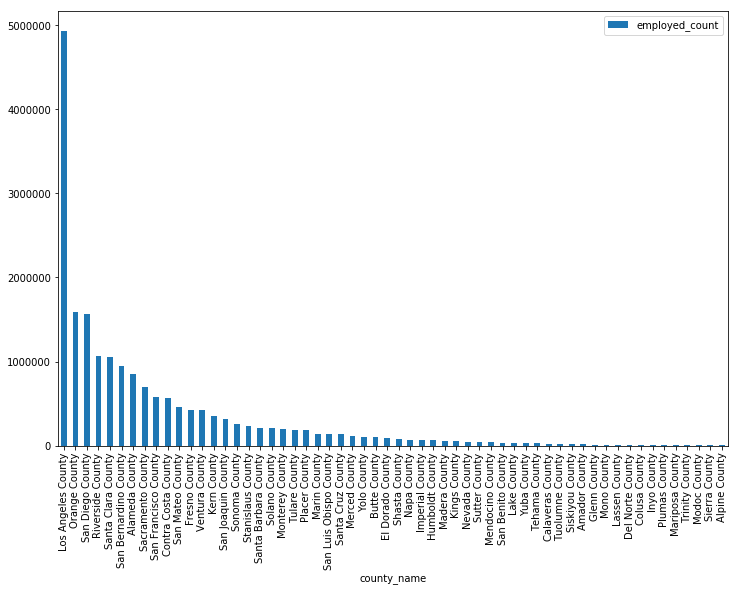

In [21]:
# Sort by employment count
final_data = data.copy()
final_data = final_data.sort_values('employed_count', ascending=False)

# Plot the bar chart
final_data.plot.bar(x='county_name', y='employed_count', rot=90, figsize=(12, 8))
plt.show()

This wraps up our tutorial on how to use the Data Commons Python API to access statistics in the knowledge graph and view it in a Pandas Data Frame. From this tutorial we should now know

- How statistics are modeled in the graph
- What API methods are available for accessing these statistics
- How to use API methods to access these statistics

Of course, one may wish to perform a more nuanced analysis of employment. For example, to really understand employment rates in a given county, we may wish to normalize the counts we queried for by the counts of various populations such as

- All persons in a county.
- All persons of working age in a county.
- All persons with or without a disability in a county.

We hope that with the tools provided in this notebook, such analysis will be easier and quicker to perform. Happy hunting!